In [32]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')

In [34]:
#req1 = req1[20000:2005000]
#gen_req1 = gen_req1[20000:2005000]
req1.shape,gen_req1.shape

((2005000,), (2255000,))

In [35]:
N = 100 # total ids 
pi = 3.14

LRU

In [36]:
def LRU(y, x, request_time,con):
  [N,I] = x.shape
  J = len(y)
  for j in range(J):
    x_t_j = np.zeros(N)
    file_req_time = np.zeros(N)

    # to find which users are connected to this cache 
    connected_users = []
    for k in range(I):
      if con[k,j] == 1:
        connected_users.append(k)
    for k in range(len(connected_users)):
      x_t_j += x[:,connected_users[k]]
      file_req_time = np.maximum(file_req_time, request_time[:,connected_users[k]])
    x_t_j = np.minimum(np.ones(N),x_t_j)

    a1 = np.transpose(np.logical_and(y[j],np.logical_not(np.logical_and(y[j],np.transpose(x_t_j)))))# file which is not requested but still in the cache
    b1 = np.transpose(np.logical_and(np.transpose(x_t_j),np.logical_not(np.logical_and(y[j],np.transpose(x_t_j))))) # file requested but not in the cache.
    a = np.sum(a1)
    b = np.sum(b1)

    if a>0 and b>0:
      if a>b:
        ind = []
        for k in range(N):
          if a1[k] == 1:
            ind.append(k)
        t = np.zeros(a)
        for k in range(a):
          t[k] = file_req_time[ind[k]]
        replace = (t).argsort()[:b]
        for k in range(b):
          y[j,ind[int(replace[k])]] = 0
        for k in range(N):
          if b1[k] == 1:
            y[j,k] = 1
      
      else:
        for k in range(N):
          if a1[k] == 1:
            y[j,k] = 0
        
        ind = []
        for k in range(N):
          if b1[k] == 1:
            ind.append(k)
        t = np.zeros(b)
        for k in range(b):
          t[k] = file_req_time[ind[k]]
        replace = (t).argsort()[:a]
        for k in range(a):
          y[j,ind[int(replace[k])]] = 1
  return y

LFU

In [37]:
def LFU(y,x,freq,con):
  [N,I] = x.shape
  J = len(y)

  for j in range(J):
    file_freq = np.zeros(N)
    x_t_j = np.zeros(N)

    # to find which users are connected to this cache 
    connected_users = []
    for k in range(I):
      if con[k,j] == 1:
        connected_users.append(k)
    for k in range(len(connected_users)):
      x_t_j += x[:,connected_users[k]]
      file_freq += freq[:,connected_users[k]]
    x_t_j = np.minimum(np.ones(N),x_t_j)

    a1 = np.transpose(np.logical_and(y[j],np.logical_not(np.logical_and(y[j],np.transpose(x_t_j)))))# file which is not requested but still in the cache
    b1 = np.transpose(np.logical_and(np.transpose(x_t_j),np.logical_not(np.logical_and(y[j],np.transpose(x_t_j))))) # file requested but not in the cache.
    a = np.sum(a1)
    b = np.sum(b1)
  
    if a>0 and b>0:
      if a>b:
        ind = []
        for k in range(N):
          if a1[k] == 1:
            ind.append(k)
        t = np.zeros(a)
        for k in range(a):
          t[k] = file_freq[ind[k]]
        replace = (t).argsort()[:b]
        for k in range(b):
          y[j,ind[int(replace[k])]] = 0
        for k in range(N):
          if b1[k] == 1:
            y[j,k] = 1
      else:
        for k in range(N):
          if a1[k] == 1:
            y[j,k] = 0
        ind = []
        for k in range(N):
          if b1[k] == 1:
            ind.append(k)
        t = np.zeros(b)
        for k in range(b):
          t[k] = file_freq[ind[k]]
        replace = (t).argsort()[:a]
        for k in range(a):
          y[j,ind[int(replace[k])]] = 1

  return y

perturbed count

In [38]:
def per_count(eta,count):
  [N,I] = count.shape
  p_count = np.zeros((N,I),dtype = float)
  for i in range(I):
    p_count[:,i] = count[:,i] + (eta*random.normal(0,1,[N,1])).reshape(N)
  return p_count

GREEDY

In [39]:
def Greedy(con,count):
  [I,J] = con.shape
  [N,I] = count.shape
  load = np.zeros((1,J),dtype = float)

  for i in range(I):
    for f in range(N):
      if count[f,i] < 0:
        count[f,i] = 0
  
  loadc = 0
  y = np.zeros((J,N),dtype = float)
  z = np.zeros((I,N),dtype = float)
  mark = np.zeros((I,N),dtype = float)

  while(loadc < J):
    best_cache = -1
    best_file = -1
    best_imp = -1

    for j in range(J):
      if load[0,j] < C:
        for f in range(N):
          if y[j,f] != 1:
            imp = 0

            for i in range(I):
              if con[i,j] == 1 and mark[i,f] == 0:
                imp += count[f,i]

            if imp >= best_imp:
              best_cache = j
              best_file = f
              best_imp = imp

    y[best_cache,best_file] = 1

    for i in range(I):
      if con[i,best_cache] == 1:
        mark[i,best_cache] = 1

    load[0,best_cache] += 1
    if load[0,best_cache] == C:
      loadc += 1
  
  for i in range(I):
    for f in range(N):
      for j in range(J):
        if con[i,j] == 1:
          z[i,f] = np.maximum(y[j,f],z[i,f])
      
  return y,z

SINGLE CACHE

In [40]:
I = 1 #users
T = 100000
degree = 1
J = 1 #caches
C = 5
connection = np.array([[1]])
connection.shape

(1, 1)

In [41]:
req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    req[i,j] = req1[(i+1)*(j+1) - 1]
req.shape

(1, 100000)

In [42]:
gen_req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    gen_req[i,j] = gen_req1[(i+1)*(j+1) - 1]
gen_req.shape

(1, 100000)

In [43]:
y_LRU = np.zeros((J,N),dtype = float)
y_LFU = np.zeros((J,N),dtype = float)
y_FTPL = np.zeros((J,N),dtype = float)
y_LSTM = np.zeros((J,N),dtype = float)
y_LSTM[:,:C] = np.ones((J,C),dtype = float)
y_FTPL[:,:C] = np.ones((J,C),dtype = float)
y_LRU[:,:C] = np.ones((J,C),dtype = float)
y_LFU[:,:C] = np.ones((J,C),dtype = float)

count = np.zeros((N,I),dtype = float)

reward_LSTM =  np.zeros(T)
reward_FTPL =  np.zeros(T)
reward_LRU =  np.zeros(T)
reward_LFU =  np.zeros(T)
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
miss_LRU =  0
miss_LSTM =  0
miss_LFU =  0
miss_FTPL =  0


req_time = np.zeros((N,I),dtype = float) 
req_time1 = np.zeros((N,I),dtype = float) 

for t in range(T):
  old_FTPL = []
  old_LRU = []
  old_LFU = []
  old_LSTM = []
  new_FTPL = []
  new_LRU = []
  new_LFU = []
  new_LSTM = []
  for j in range(J):
    for k in range(N):
      old_LRU.append(y_LRU[j,k])
      old_LFU.append(y_LFU[j,k])
      old_FTPL.append(y_FTPL[j,k])
      old_LSTM.append(y_LSTM[j,k])

  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros(I)
  ireward_LSTM =  np.zeros(I)
  ireward_LFU =  np.zeros(I)
  ireward_FTPL =  np.zeros(I)
  
  for i in range(I):
    temp1 = np.zeros(N)
    temp2 = np.zeros(N)
    temp3 = np.zeros(N)
    temp4 = np.zeros(N)
    connected_cache = []
    for j in range(J):
      if connection[i,j] == 1:
        connected_cache.append(j)
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)


  y_LFU = LFU(y_LFU,x_t,count,connection)
  y_LRU = LRU(y_LRU,x_t,req_time,connection)
  y_LSTM = LRU(y_LSTM,x_t1,req_time1,connection)

  eta = pow(4*pi*np.log(N),-.25)*pow((t+1)/C,.5)
  perturbed_count=per_count(eta,count)

  add = (-perturbed_count[:,0]).argsort()[:C]
  y_FTPL = np.zeros((J,N),dtype = float)
  for k in range(len(add)):
    y_FTPL[0,int(add[k])] = 1 
 
  for j in range(J):
    for k in range(N):
      new_LRU.append(y_LRU[j,k])
      new_LFU.append(y_LFU[j,k])
      new_FTPL.append(y_FTPL[j,k])
      new_LSTM.append(y_LSTM[j,k])
  
  miss_FTPL += (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))
  miss_LFU += (np.sum(np.logical_and(new_LFU,np.logical_not(old_LFU))))
  miss_LRU += (np.sum(np.logical_and(new_LRU,np.logical_not(old_LRU))))
  miss_LSTM += (np.sum(np.logical_and(new_LSTM,np.logical_not(old_LSTM))))
  download_LFU.append(miss_LFU)
  download_LRU.append(miss_LRU)
  download_FTPL.append(miss_FTPL)
  download_LSTM.append(miss_LSTM)

  hits_LRU.append(reward_LRUc)
  hits_LFU.append(reward_LFUc)
  hits_FTPL.append(reward_FTPLc)
  hits_LSTM.append(reward_LSTMc)

  if t %10000 == 0:
    print(t,download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t])

0 5 1 1 1
10000 37075 9397 9477 9477
20000 63530 18715 18994 18994
30000 85491 28029 28465 27616
40000 102594 37355 37919 36214
50000 117600 46740 47407 44815
60000 130541 56073 56865 53412
70000 141903 65392 66324 62018
80000 152783 74733 75808 70578
90000 162559 84087 85340 79217


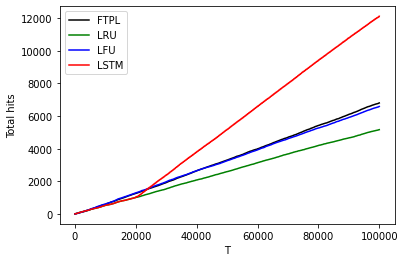

In [44]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('Total hits')
plt.legend()
plt.savefig('Total hits(I=J=1).png')

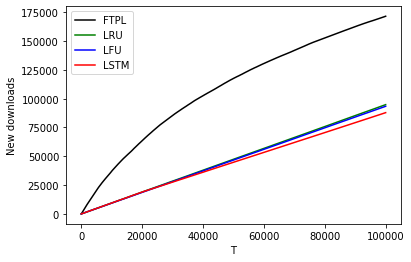

In [45]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('New downloads')
plt.legend()
plt.savefig('New downloads(I=J=1).png')

I = 5 J = 3 d = 2

In [46]:
C = 5
I = 5
J = 3
degree = 3
T = 20000

In [47]:
connection = np.zeros((I,J),dtype = int)
i = 0
for j in range(J):
  x = 0
  while x < degree:
    connection[i,j] = 1
    x += 1
    i += 1
    if i == I:
      i = 0
connection

array([[1, 1, 0],
       [1, 0, 1],
       [1, 0, 1],
       [0, 1, 1],
       [0, 1, 0]])

In [48]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')
req1 = req1[20000:2005000]
gen_req1 = gen_req1[20000:2005000]

In [49]:
req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    req[i,j] = req1[(i+1)*(j+1) - 1]
req.shape

(5, 20000)

In [50]:
gen_req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    gen_req[i,j] = gen_req1[(i+1)*(j+1) - 1]
gen_req.shape

(5, 20000)

In [51]:
y_LRU = np.zeros((J,N),dtype = float)
y_LFU = np.zeros((J,N),dtype = float)
y_FTPL = np.zeros((J,N),dtype = float)
y_LSTM = np.zeros((J,N),dtype = float)
y_LSTM[:,:C] = np.ones((J,C),dtype = float)
y_FTPL[:,:C] = np.ones((J,C),dtype = float)
y_LRU[:,:C] = np.ones((J,C),dtype = float)
y_LFU[:,:C] = np.ones((J,C),dtype = float)

count = np.zeros((N,I),dtype = float)

reward_LSTM =  np.zeros(T)
reward_FTPL =  np.zeros(T)
reward_LRU =  np.zeros(T)
reward_LFU =  np.zeros(T)
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
miss_LRU =  0
miss_LSTM =  0
miss_LFU =  0
miss_FTPL =  0


req_time = np.zeros((N,I),dtype = float) 
req_time1 = np.zeros((N,I),dtype = float) 

for t in range(T):
  old_FTPL = []
  old_LRU = []
  old_LFU = []
  old_LSTM = []
  new_FTPL = []
  new_LRU = []
  new_LFU = []
  new_LSTM = []
  for j in range(J):
    for k in range(N):
      old_LRU.append(y_LRU[j,k])
      old_LFU.append(y_LFU[j,k])
      old_FTPL.append(y_FTPL[j,k])
      old_LSTM.append(y_LSTM[j,k])
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros(I)
  ireward_LSTM =  np.zeros(I)
  ireward_LFU =  np.zeros(I)
  ireward_FTPL =  np.zeros(I)
  
  for i in range(I):
    temp1 = np.zeros(N)
    temp2 = np.zeros(N)
    temp3 = np.zeros(N)
    temp4 = np.zeros(N)
    connected_cache = []
    for j in range(J):
      if connection[i,j] == 1:
        connected_cache.append(j)
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)


  y_LFU = LFU(y_LFU,x_t,count,connection)
  y_LRU = LRU(y_LRU,x_t,req_time,connection)
  y_LSTM = LRU(y_LSTM,x_t1,req_time1,connection)

  eta = I*pow(4*pi*np.log(N*I),-0.25)*pow((t+1)/(J*degree*C),.5)
  perturbed_count=per_count(eta,count)

  [y_FTPL,z] = Greedy(connection,perturbed_count)
  for j in range(J):
    for k in range(N):
      new_LRU.append(y_LRU[j,k])
      new_LFU.append(y_LFU[j,k])
      new_FTPL.append(y_FTPL[j,k])
      new_LSTM.append(y_LSTM[j,k])
  
#  print(old_LRU)
  miss_FTPL += (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))
  miss_LFU += (np.sum(np.logical_and(new_LFU,np.logical_not(old_LFU))))
  miss_LRU += (np.sum(np.logical_and(new_LRU,np.logical_not(old_LRU))))
  miss_LSTM += (np.sum(np.logical_and(new_LSTM,np.logical_not(old_LSTM))))
  download_LFU.append(miss_LFU)
  download_LRU.append(miss_LRU)
  download_FTPL.append(miss_FTPL)
  download_LSTM.append(miss_LSTM)

  hits_LRU.append(reward_LRUc)
  hits_LFU.append(reward_LFUc)
  hits_FTPL.append(reward_FTPLc)
  hits_LSTM.append(reward_LSTMc)

  if t %1000 == 0:
    print(t,download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t],hits_FTPL[t],hits_LFU[t],hits_LRU[t],hits_LSTM[t])

0 15 9 9 9 0.0 0.0 0.0 0.0
1000 13274 8376 8422 8147 444.0 416.0 388.0 574.0
2000 25863 16748 16839 16317 879.0 834.0 782.0 1141.0
3000 37547 25136 25282 24441 1313.0 1222.0 1140.0 1718.0
4000 48190 33436 33679 32589 1786.0 1651.0 1527.0 2301.0
5000 58053 41763 42085 40642 2214.0 2056.0 1901.0 2922.0
6000 67501 50134 50491 48752 2656.0 2455.0 2287.0 3521.0
7000 76667 58467 58877 56856 3110.0 2842.0 2693.0 4111.0
8000 85510 66881 67332 65002 3496.0 3193.0 3046.0 4686.0
9000 94170 75292 75786 73105 3926.0 3569.0 3411.0 5265.0
10000 102471 83722 84268 81197 4372.0 3923.0 3744.0 5888.0
11000 110585 92097 92707 89344 4801.0 4299.0 4115.0 6460.0
12000 118341 100493 101143 97447 5224.0 4654.0 4463.0 7057.0
13000 126016 108890 109581 105480 5644.0 5030.0 4825.0 7679.0
14000 133728 117270 118017 113614 6076.0 5413.0 5193.0 8251.0
15000 141145 125650 126483 121757 6529.0 5795.0 5538.0 8844.0
16000 148424 134002 134887 129874 6910.0 6165.0 5927.0 9456.0
17000 155789 142417 143370 137957 7330.0 65

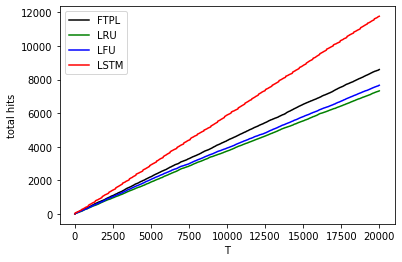

In [52]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('total hits')
plt.legend()
plt.savefig('Total hits(I=5 J=3 d=2).png')

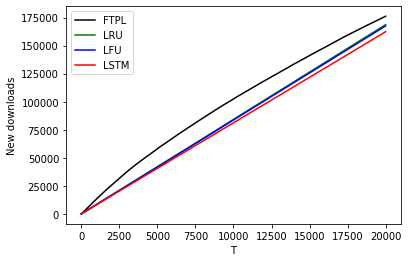

In [53]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('New downloads')
plt.legend()
plt.savefig('New downloads(I=5 J=3 d=2).png')

I = 15 J = 10 d = 7

In [54]:
I = 15
J = 10
C = 10
degree = 7
T = 10000

In [55]:
connection = np.zeros((I,J),dtype = int)
i = 0
for j in range(J):
  x = 0
  while x < degree:
    connection[i,j] = 1
    x += 1
    i += 1
    if i == I:
      i = 0
connection

array([[1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 0, 1],
       [1, 0, 1, 0, 1, 0, 0, 1, 0, 1],
       [1, 0, 1, 0, 0, 1, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 1, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 1, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 1, 0]])

In [56]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')
req1 = req1[20000:2005000]
gen_req1 = gen_req1[20000:2005000]

In [57]:
req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    req[i,j] = req1[(i+1)*(j+1) - 1]
req.shape

(15, 10000)

In [58]:
gen_req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    gen_req[i,j] = gen_req1[(i+1)*(j+1) - 1]
gen_req.shape

(15, 10000)

In [59]:
y_LRU = np.zeros((J,N),dtype = float)
y_LFU = np.zeros((J,N),dtype = float)
y_FTPL = np.zeros((J,N),dtype = float)
y_LSTM = np.zeros((J,N),dtype = float)
y_LSTM[:,:C] = np.ones((J,C),dtype = float)
y_FTPL[:,:C] = np.ones((J,C),dtype = float)
y_LRU[:,:C] = np.ones((J,C),dtype = float)
y_LFU[:,:C] = np.ones((J,C),dtype = float)

count = np.zeros((N,I),dtype = float)

reward_LSTM =  np.zeros(T)
reward_FTPL =  np.zeros(T)
reward_LRU =  np.zeros(T)
reward_LFU =  np.zeros(T)
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
miss_LRU =  0
miss_LSTM =  0
miss_LFU =  0
miss_FTPL =  0

req_time = np.zeros((N,I),dtype = float) 
req_time1 = np.zeros((N,I),dtype = float) 

for t in range(T):
  old_FTPL = []
  old_LRU = []
  old_LFU = []
  old_LSTM = []
  new_FTPL = []
  new_LRU = []
  new_LFU = []
  new_LSTM = []
  for j in range(J):
    for k in range(N):
      old_LRU.append(y_LRU[j,k])
      old_LFU.append(y_LFU[j,k])
      old_FTPL.append(y_FTPL[j,k])
      old_LSTM.append(y_LSTM[j,k])
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros(I)
  ireward_LSTM =  np.zeros(I)
  ireward_LFU =  np.zeros(I)
  ireward_FTPL =  np.zeros(I)
  
  for i in range(I):
    temp1 = np.zeros(N)
    temp2 = np.zeros(N)
    temp3 = np.zeros(N)
    temp4 = np.zeros(N)
    connected_cache = []
    for j in range(J):
      if connection[i,j] == 1:
        connected_cache.append(j)
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)

  y_LFU = LFU(y_LFU,x_t,count,connection)
  y_LRU = LRU(y_LRU,x_t,req_time,connection)
  y_LSTM = LRU(y_LSTM,x_t1,req_time1,connection)

  eta = I*pow(4*pi*np.log(N*I),-0.25)*pow((t+1)/(J*degree*C),.5)
  perturbed_count=per_count(eta,count)
  [y_FTPL,z] = Greedy(connection,perturbed_count)

  for j in range(J):
    for k in range(N):
      new_LRU.append(y_LRU[j,k])
      new_LFU.append(y_LFU[j,k])
      new_FTPL.append(y_FTPL[j,k])
      new_LSTM.append(y_LSTM[j,k])
  
#  print(old_LRU)
  miss_FTPL += (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))
  miss_LFU += (np.sum(np.logical_and(new_LFU,np.logical_not(old_LFU))))
  miss_LRU += (np.sum(np.logical_and(new_LRU,np.logical_not(old_LRU))))
  miss_LSTM += (np.sum(np.logical_and(new_LSTM,np.logical_not(old_LSTM))))
  download_LFU.append(miss_LFU)
  download_LRU.append(miss_LRU)
  download_FTPL.append(miss_FTPL)
  download_LSTM.append(miss_LSTM)

  hits_LRU.append(reward_LRUc)
  hits_LFU.append(reward_LFUc)
  hits_FTPL.append(reward_FTPLc)
  hits_LSTM.append(reward_LSTMc)

  if t %1000 == 0:
    print(t,download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t],hits_FTPL[t],hits_LFU[t],hits_LRU[t],hits_LSTM[t])

0 98 65 65 53 1.0 1.0 1.0 0.0
1000 66608 60185 60847 58863 3627.0 2792.0 2585.0 3052.0
2000 124196 120399 121831 117444 6802.0 5486.0 5139.0 6222.0
3000 173523 180639 182770 175700 9912.0 8088.0 7742.0 9425.0
4000 216427 240664 243607 234066 12957.0 10693.0 10349.0 12617.0
5000 255383 300924 304581 291944 15837.0 13271.0 12910.0 15924.0
6000 291467 361163 365637 350642 18730.0 15832.0 15459.0 19046.0
7000 324349 421381 426412 408916 21508.0 18458.0 18088.0 22270.0
8000 356413 481611 487328 467193 24298.0 21039.0 20682.0 25498.0
9000 387304 541865 548362 525182 27064.0 23620.0 23275.0 28689.0


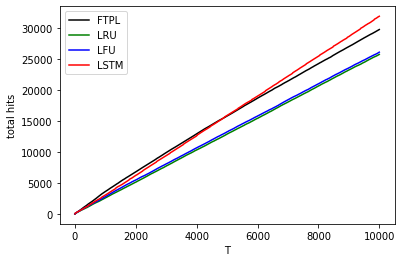

In [60]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('total hits')
plt.legend()
plt.savefig('Total hits(I=15 J=10 d=7).png')

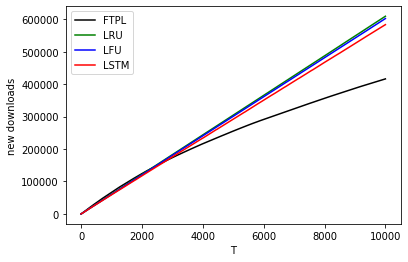

In [61]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('new downloads')
plt.legend()
plt.savefig('New downloads(I=15 J=10 d=7).png')